# Imports

In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import sys
import warnings
warnings.filterwarnings('ignore')

!{sys.executable} -m pip install xgboost


# 1: Data Preprocessing


## 1.1: Loading GameData.csv Dataset

In [5]:
# Load the dataset
data = pd.read_csv('GameData.csv')

# Preliminary data exploration
print("--------------")
print("Dataset shape (rows x columns): ")
print(data.shape)
print("--------------")
print("\nDataset information: ")
print(data.info())
print("--------------")
print("\nDataset summary statistics: ")
print(data.describe(include='all'))
print("--------------")
print("\nDataset snapshot (Head): ")
print(data.head())


--------------
Dataset shape (rows x columns): 
(403, 386)
--------------

Dataset information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Columns: 386 entries, GameName to UCT
dtypes: float64(5), int64(377), object(4)
memory usage: 1.2+ MB
None
--------------

Dataset summary statistics: 
       GameName  String_java.lang.String     Off_int     End_int     int_int  \
count       403               403.000000  403.000000  403.000000   14.000000   
unique      403                      NaN         NaN         NaN         NaN   
top       Senet                      NaN         NaN         NaN         NaN   
freq          1                      NaN         NaN         NaN         NaN   
mean        NaN                24.970223    0.362283    0.133995   39.571429   
std         NaN               115.039293    1.175101    0.720635   58.952020   
min         NaN                 2.000000    0.000000    0.000000    2.000000   
25%         NaN                 6.00000

## 1.2: Checking and Handling Null Values


In [6]:
# Check for missing values
missing_values = data.isnull().sum()
# Filtering columns with missing values
missing_values = missing_values[missing_values > 0]
# Display missing values
print("\nMissing Values per Column:")
print(missing_values)

# Drop 'int_int' column: Contains 389/403 null values
if 'int_int' in data.columns:
    data = data.drop(columns=['int_int'])
    print("\nDropped 'int_int' column.")
else:
    print("\nColumn 'int_int' not found. Skipping drop.")

print("\n--------------")
print("\nColumns after dropping 'int_int':")
print(data.columns.tolist())
print("\n--------------")



# Define columns to impute - predfined in previous exploration
columns_to_impute = [
    'Board_game.equipment.container.board.Board',
    'Equipment_game.equipment.Equipment',
    'To_game.functions.ints.iterator.To'
]

# Initialise simple imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

print("\nMissing Values after Imputation:")
print(data[columns_to_impute].isnull().sum())




Missing Values per Column:
int_int                                       389
Board_game.equipment.container.board.Board      1
Equipment_game.equipment.Equipment              1
To_game.functions.ints.iterator.To              3
dtype: int64

Dropped 'int_int' column.

--------------

Columns after dropping 'int_int':
['GameName', 'String_java.lang.String', 'Off_int', 'End_int', 'Undefined_int', 'Piece_game.equipment.component.Piece', 'Board_game.equipment.container.board.Board', 'MancalaBoard_game.equipment.container.board.custom.MancalaBoard', 'Track_game.equipment.container.board.Track', 'Dice_game.equipment.container.other.Dice', 'Hand_game.equipment.container.other.Hand', 'Equipment_game.equipment.Equipment', 'Map_game.equipment.other.Map', 'Regions_game.equipment.other.Regions', 'All_game.functions.booleans.all.All', 'Can_game.functions.booleans.can.Can', 'Is_game.functions.booleans.is.Is', 'And_game.functions.booleans.math.And', 'Equals_game.functions.booleans.math.Equals', 'Ge_g

## 1.3: Encode Categorical Variables


In [7]:
# Initialise LabelEncoders()

le_category = LabelEncoder()
le_region = LabelEncoder()
le_bestagent = LabelEncoder()

# Encoding target variables
data['Category_encoded'] = le_category.fit_transform(data['Category'])
data['Region_encoded'] = le_region.fit_transform(data['Region'])
data['BestAgent_encoded'] = le_bestagent.fit_transform(data['BestAgent'])

print("\nEncoded Target Variables:")
print(data[['Category', 'Category_encoded']].head())
print(data[['Region', 'Region_encoded']].head())
print(data[['BestAgent', 'BestAgent_encoded']].head())



Encoded Target Variables:
  Category  Category_encoded
0     Race                 2
1      War                 5
2     Race                 2
3      War                 5
4     Race                 2
            Region  Region_encoded
0  Northern Africa               8
1  Northern Africa               8
2  Northern Africa               8
3  Northern Africa               8
4  Northern Africa               8
             BestAgent  BestAgent_encoded
0  Progressive History                  3
1           Alpha-Beta                  0
2           Alpha-Beta                  0
3                 MAST                  1
4                 MAST                  1


## 1.4 : Select Feature Columns


In [8]:
# Columns to exclude from features
exclude_columns = [
    'GameName', 'Category', 'Region', 'OriginYear', 'BestAgent', 'UCT',
    'Category_encoded', 'Region_encoded', 'BestAgent_encoded'
]

# Drop excluded columns to get feature set
X_features = data.drop(columns=exclude_columns)

# List of feature column names
feature_columns = X_features.columns.tolist()

print("\nNumber of Feature Columns:", len(feature_columns))
print("\nFirst 10 Feature Columns:", feature_columns[:10])


# Drop excluded columns to get feature set
X_features = data.drop(columns=exclude_columns)

# List of feature column names
feature_columns = X_features.columns.tolist()

print("\nNumber of Feature Columns:", len(feature_columns))
print("\nFirst 10 Feature Columns:", feature_columns[:10])

# Initialise the scaler
scaler = StandardScaler()

# Scale fit and transform all features
X_features_scaled = scaler.fit_transform(X_features)

# Convert the scaled features back to a dataframe
df_X_features = pd.DataFrame(X_features_scaled, columns=feature_columns)

print("\nShape of feature matrix set:", X_features_scaled.shape)

# Define target variables
targets = ['Category', 'Region', 'BestAgent']
target_encoded = ['Category_encoded', 'Region_encoded', 'BestAgent_encoded']


# Performing separate train_test_split for each target to maintain target-specific data integrity
train_test_splits = {}
for target, encoded_target in zip(targets, target_encoded):
    print(f"\nPerforming train_test_split for target: {target}")

    # Check for class distribution before splitting
    class_counts = data[encoded_target].value_counts()

    # If any class has less than 2 samples, skip stratification for that target
    if class_counts.min() < 2:
        print(f"Warning: Target '{target}' has a class with less than 2 samples. Skipping stratification.")
        X_train, X_test, y_train, y_test = train_test_split(
            X_features_scaled,
            data[encoded_target],
            test_size=0.2,
            random_state=42,
            # Remove stratify for this target
            #stratify=data[encoded_target]
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_features_scaled,
            data[encoded_target],
            test_size=0.2,
            random_state=42,
            stratify=data[encoded_target]
        )

    train_test_splits[target] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    print(f"Training Features Shape: {X_train.shape}")
    print(f"Testing Features Shape: {X_test.shape}")
    print(f"Training Target '{target}' Shape: {y_train.shape}")
    print(f"Testing Target '{target}' Shape: {y_test.shape}")


Number of Feature Columns: 379

First 10 Feature Columns: ['String_java.lang.String', 'Off_int', 'End_int', 'Undefined_int', 'Piece_game.equipment.component.Piece', 'Board_game.equipment.container.board.Board', 'MancalaBoard_game.equipment.container.board.custom.MancalaBoard', 'Track_game.equipment.container.board.Track', 'Dice_game.equipment.container.other.Dice', 'Hand_game.equipment.container.other.Hand']

Number of Feature Columns: 379

First 10 Feature Columns: ['String_java.lang.String', 'Off_int', 'End_int', 'Undefined_int', 'Piece_game.equipment.component.Piece', 'Board_game.equipment.container.board.Board', 'MancalaBoard_game.equipment.container.board.custom.MancalaBoard', 'Track_game.equipment.container.board.Track', 'Dice_game.equipment.container.other.Dice', 'Hand_game.equipment.container.other.Hand']

Shape of feature matrix set: (403, 379)

Performing train_test_split for target: Category
Training Features Shape: (322, 379)
Testing Features Shape: (81, 379)
Training Targ

# 2: Dimensionality Reduction and Data Visualisation


## 2.1: Principal Component Analysis (PCA)

In [9]:
# Initialise PCA to retain 95% variance across all features
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_features_scaled)

# Print PCA Components
print("\nPCA Components:")
print(pca.components_)
print("---------------")

# Create a dataframe for PCA components
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)
pca_df['Category_encoded'] = data['Category_encoded'].values
pca_df['Region_encoded'] = data['Region_encoded'].values
pca_df['BestAgent_encoded'] = data['BestAgent_encoded'].values

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("\nExplained Variance Ratio: ")
print(pca.explained_variance_ratio_)
print("---------------")
print(f"Cumulative Explained Variance: {cumulative_variance}")
print("\n---------------\n")

# Sanity check
print(f"\nOriginal number of features: {X_features_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")
print("------------------------")

# Select first two principal components for plotting
pc1 = pca_df['PC1']
pc2 = pca_df['PC2']


PCA Components:
[[ 0.12649862  0.01657516 -0.00163256 ...  0.11835524  0.00434675
   0.00426737]
 [ 0.04301524  0.04729546  0.01457304 ... -0.09907046  0.00354959
   0.00461845]
 [ 0.01027858  0.02794605  0.02780475 ...  0.02030474 -0.04012577
  -0.03862489]
 ...
 [-0.0045962  -0.059854    0.0464298  ...  0.00301162 -0.01778991
  -0.03809043]
 [-0.0019932  -0.050987   -0.06119543 ...  0.00179199  0.00460754
  -0.00470865]
 [-0.00061443  0.01610376  0.06093028 ... -0.00109923 -0.0038146
   0.02473867]]
---------------

Explained Variance Ratio: 
[0.15669389 0.04249258 0.03969601 0.03629584 0.03314393 0.02962659
 0.0267069  0.02400458 0.0222922  0.02156499 0.01855298 0.01790556
 0.01641695 0.01499362 0.01468319 0.01387806 0.01349741 0.01338764
 0.01265455 0.01234453 0.01168632 0.01133748 0.01116559 0.01077721
 0.01050024 0.00970746 0.00951567 0.00936423 0.00884242 0.00882861
 0.00860112 0.00845715 0.00803647 0.00780701 0.0075417  0.00721781
 0.00719994 0.00710825 0.00683173 0.00661694 0

## 2.2: PCA Plots

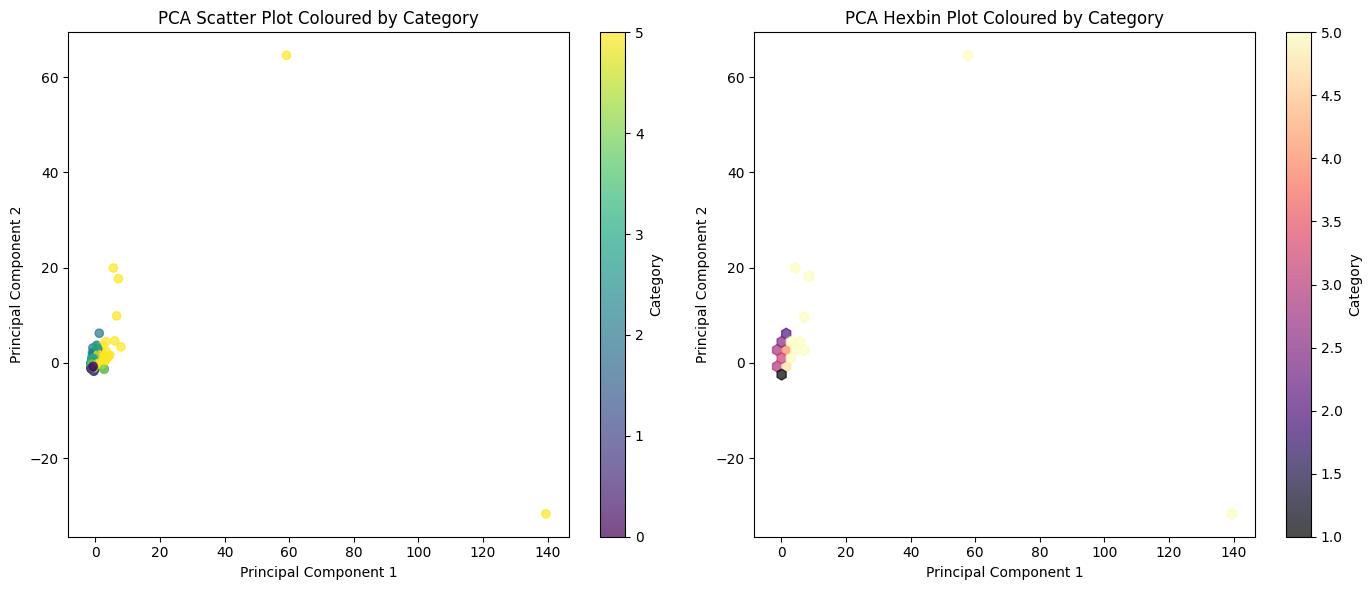

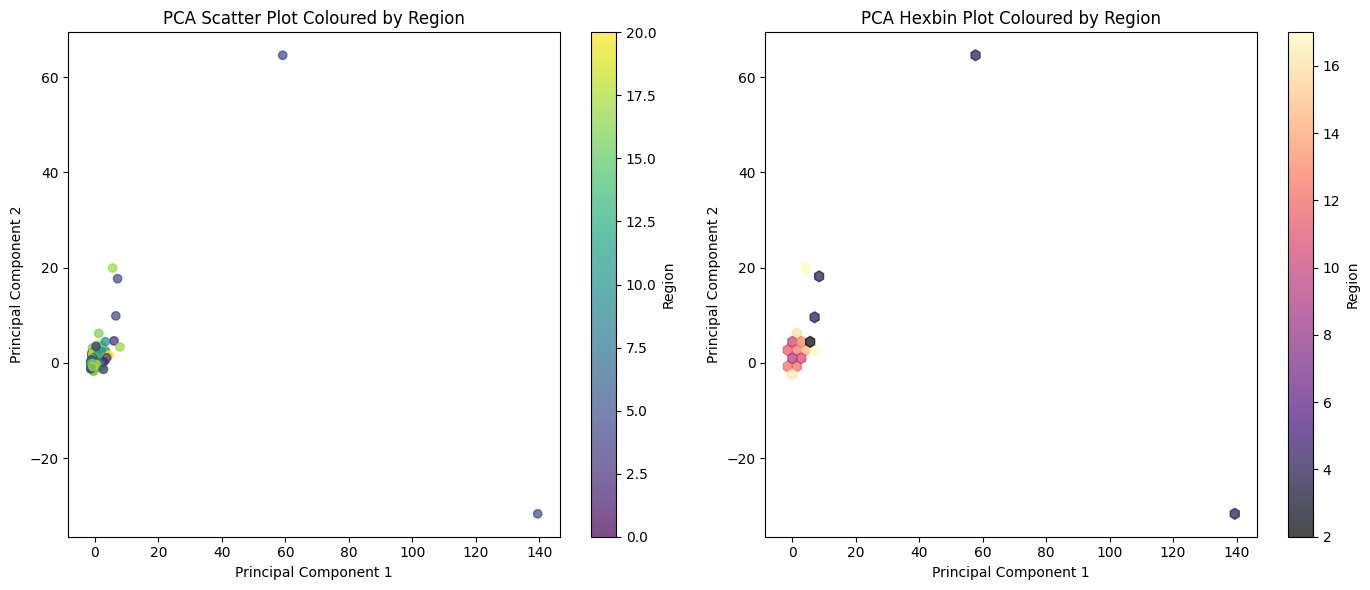

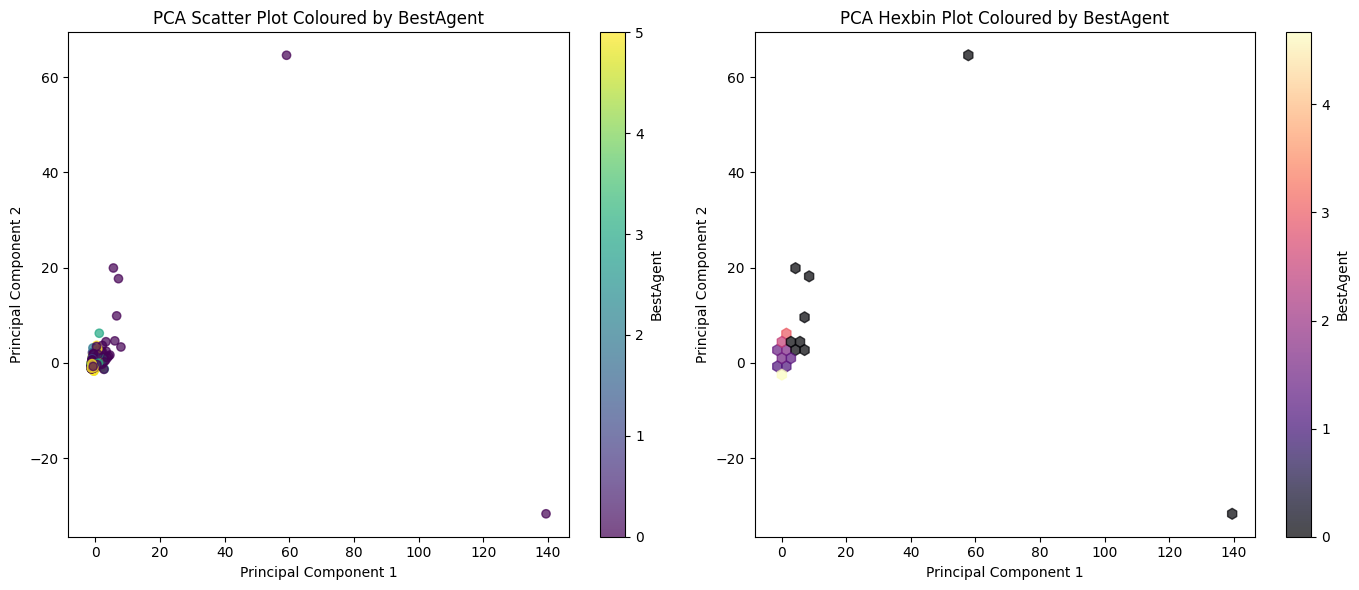

In [10]:
# ---------------------------Plots-------------------------
# Defined function to plot PCA scatter and hexbin plots for given target
def plot_pca(target_encoded, le):
    plt.figure(figsize=(14, 6))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(pc1, pc2, c=pca_df[target_encoded], cmap='viridis', alpha=0.7)
    plt.title(f'PCA Scatter Plot Coloured by {target_encoded.split("_")[0]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    cbar = plt.colorbar(scatter)
    cbar.set_label(target_encoded.split("_")[0])

    # Convert encoded labels back to original for hexbin plot
    categories = le.classes_
    mapped_labels = data[target_encoded].map(lambda x: x if isinstance(x, int) else x)

    # Hexbin Plot
    plt.subplot(1, 2, 2)
    hb = plt.hexbin(pc1, pc2, C=pca_df[target_encoded], gridsize=50, cmap='magma', reduce_C_function=np.mean, alpha=0.7)
    plt.title(f'PCA Hexbin Plot Coloured by {target_encoded.split("_")[0]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    cbar = plt.colorbar(hb)
    cbar.set_label(target_encoded.split("_")[0])

    plt.tight_layout()
    plt.show()

# Plot PCA for each label
plot_pca('Category_encoded', le_category)
plot_pca('Region_encoded', le_region)
plot_pca('BestAgent_encoded', le_bestagent)


## 2.3: t-SNE Plots Before Applying PCA


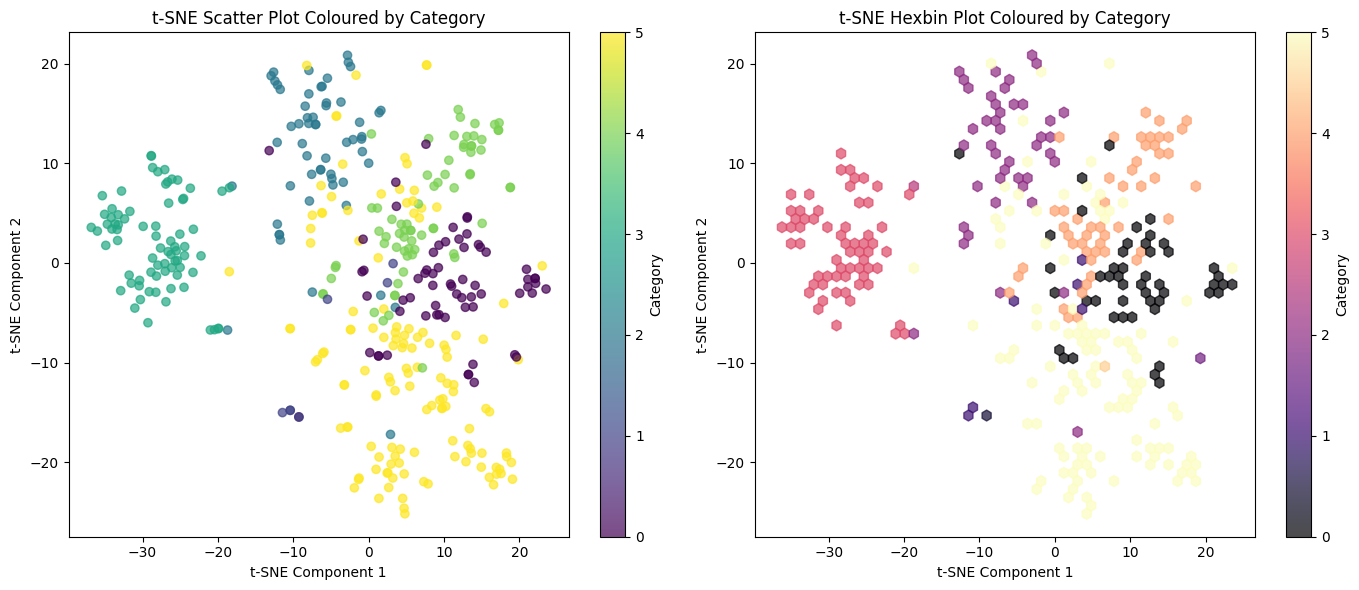

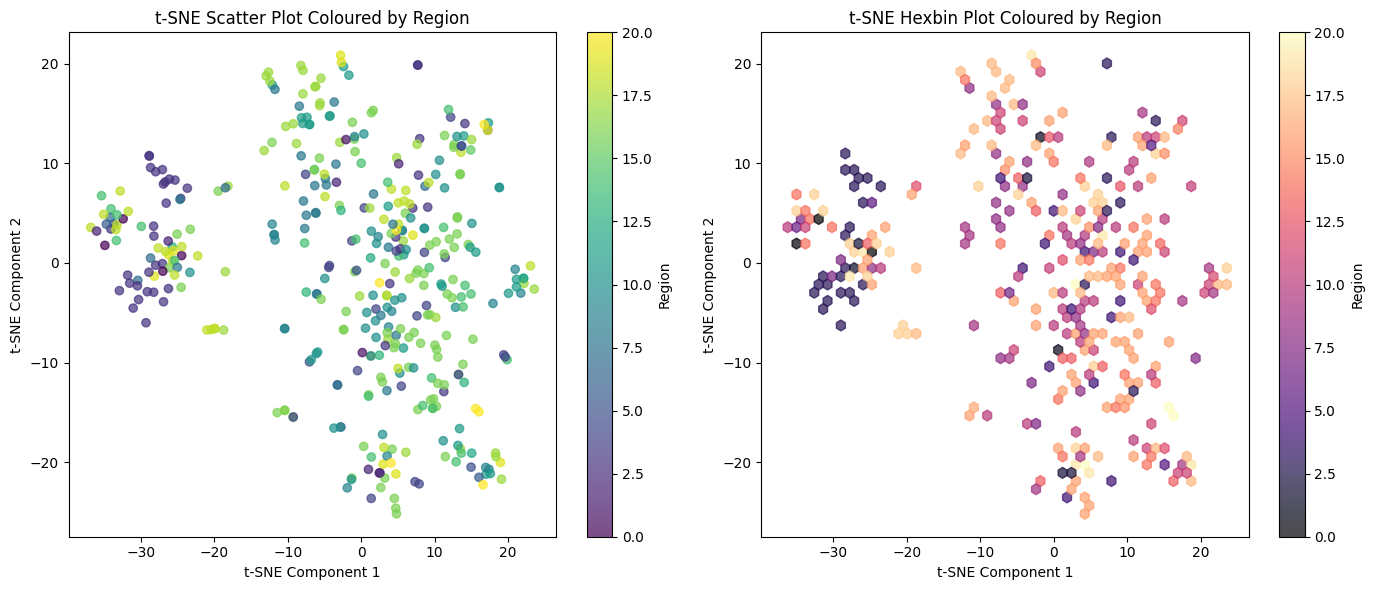

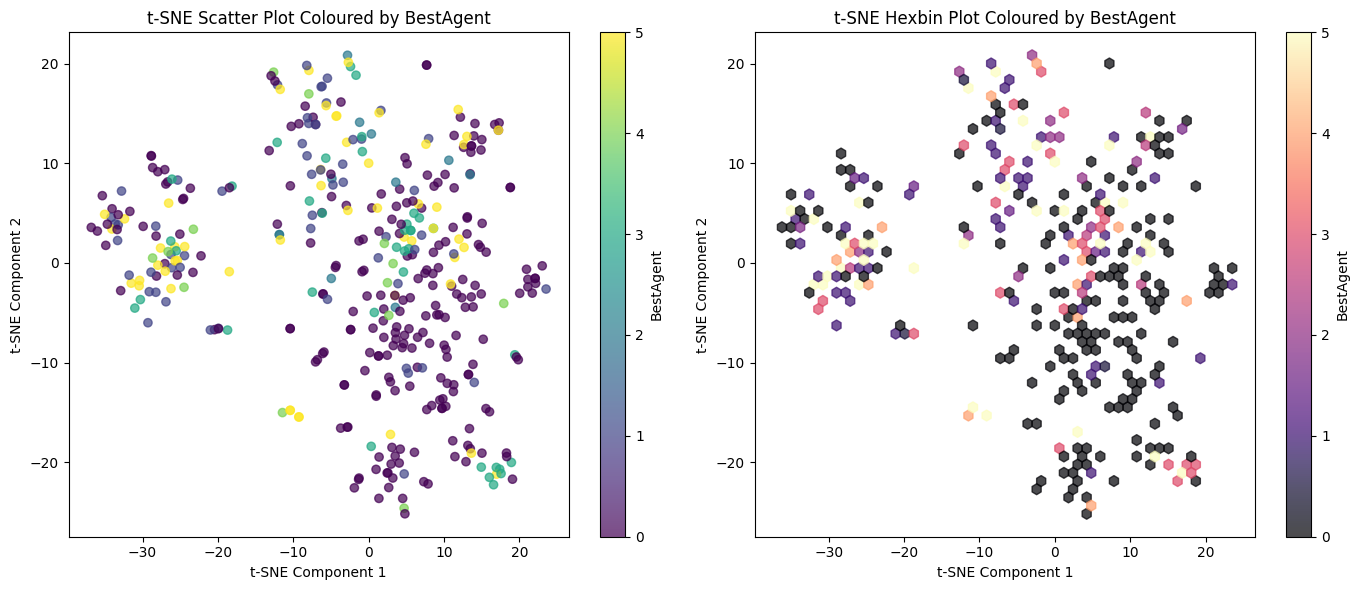

In [11]:


# Initialise t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_features_scaled)

# Create a dataframe for t-SNE components
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])

# ---------------------------Plots-------------------------
# Defined function to plot TSNE scatter and hexbin plots for given target
def plot_tsne(target_encoded, le):
    plt.figure(figsize=(14, 6))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    # Add the target_encoded column to tsne_df if it doesn't exist to prevent conflict
    if target_encoded not in tsne_df.columns:
        tsne_df[target_encoded] = data[target_encoded].values
    scatter = plt.scatter(tsne_df['tSNE1'], tsne_df['tSNE2'], c=tsne_df[target_encoded], cmap='viridis', alpha=0.7)
    plt.title(f't-SNE Scatter Plot Coloured by {target_encoded.split("_")[0]}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(scatter)
    cbar.set_label(target_encoded.split("_")[0])

    # Hexbin Plot
    plt.subplot(1, 2, 2)
    hb = plt.hexbin(tsne_df['tSNE1'], tsne_df['tSNE2'], C=tsne_df[target_encoded], gridsize=50, cmap='magma', reduce_C_function=np.mean, alpha=0.7)
    plt.title(f't-SNE Hexbin Plot Coloured by {target_encoded.split("_")[0]}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(hb)
    cbar.set_label(target_encoded.split("_")[0])

    plt.tight_layout()
    plt.show()

# Plot t-SNE for each label
plot_tsne('Category_encoded', le_category)
plot_tsne('Region_encoded', le_region)
plot_tsne('BestAgent_encoded', le_bestagent)

## 2.4: t-SNE Plots After Applying PCA

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 403 samples in 0.001s...
[t-SNE] Computed neighbors for 403 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 403 / 403
[t-SNE] Mean sigma: 3.015825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.734970
[t-SNE] KL divergence after 1000 iterations: 0.449761


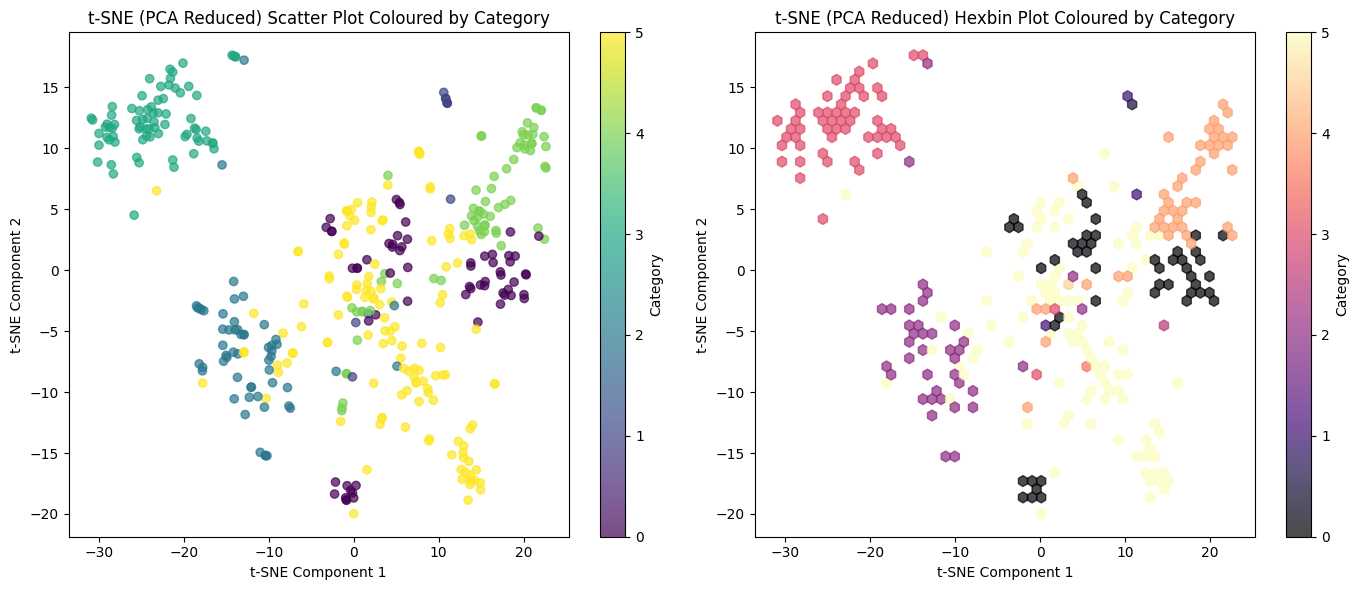

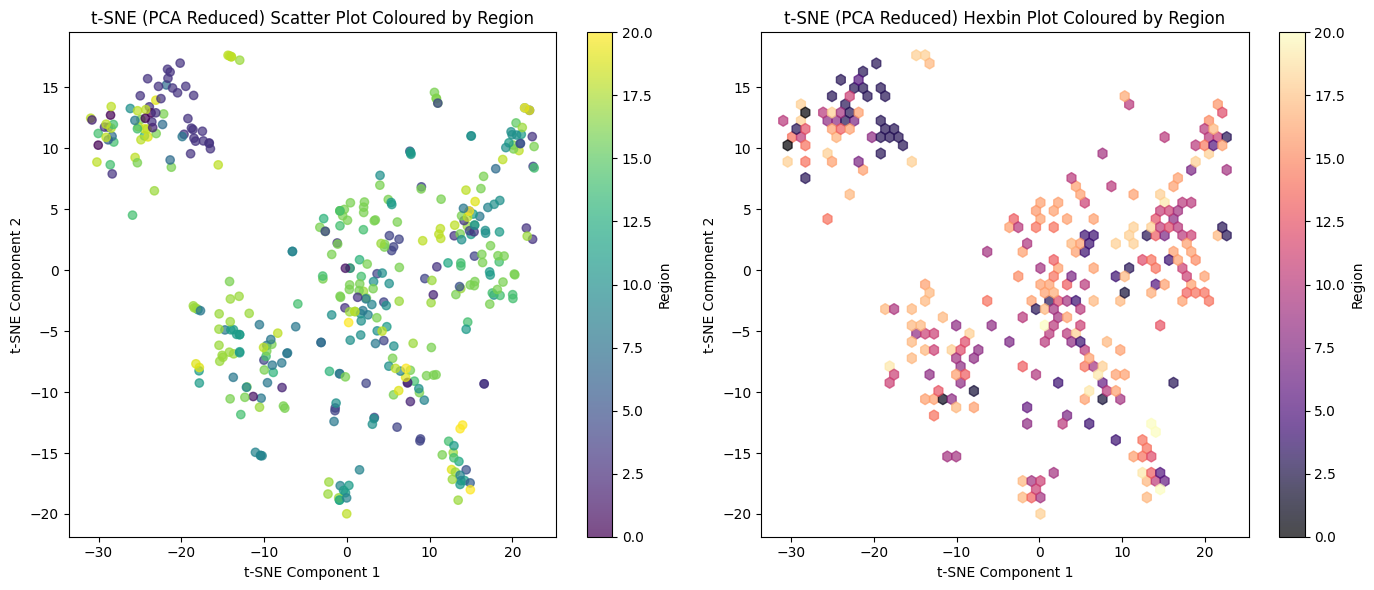

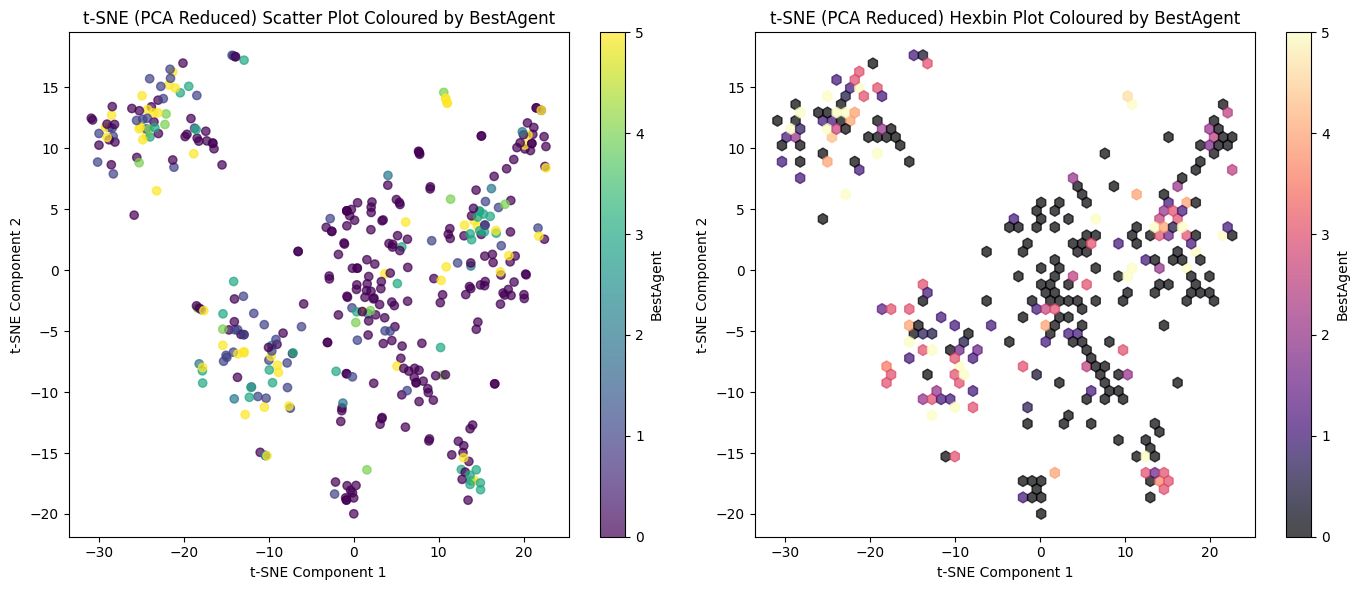

In [12]:
# Reduce dimensions with PCA before t-SNE
pca_for_tsne = PCA(n_components=50, random_state=42)
X_pca_50 = pca_for_tsne.fit_transform(X_features_scaled)

# Initialise TSNE
tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)

# Fit TSNE on PCA reduced data
X_tsne_pca = tsne_pca.fit_transform(X_pca_50)

# Create datagrame for TSNE results
tsne_pca_df = pd.DataFrame({
    'tSNE1': X_tsne_pca[:, 0],
    'tSNE2': X_tsne_pca[:, 1],
    'Category_encoded': data['Category_encoded'].values,
    'Region_encoded': data['Region_encoded'].values,
    'BestAgent_encoded': data['BestAgent_encoded'].values
})

# ---------------------------Plots-------------------------
# Defined function to plot t-SNE (PCA Reduced) scatter and hexbin plots for a given target
def plot_tsne_pca(target_encoded, le):
    plt.figure(figsize=(14, 6))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(tsne_pca_df['tSNE1'], tsne_pca_df['tSNE2'], c=tsne_pca_df[target_encoded], cmap='viridis', alpha=0.7)
    plt.title(f't-SNE (PCA Reduced) Scatter Plot Coloured by {target_encoded.split("_")[0]}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(scatter)
    cbar.set_label(target_encoded.split("_")[0])

    # Hexbin Plot
    plt.subplot(1, 2, 2)
    hb = plt.hexbin(tsne_pca_df['tSNE1'], tsne_pca_df['tSNE2'], C=tsne_pca_df[target_encoded], gridsize=50, cmap='magma', reduce_C_function=np.mean, alpha=0.7)
    plt.title(f't-SNE (PCA Reduced) Hexbin Plot Coloured by {target_encoded.split("_")[0]}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(hb)
    cbar.set_label(target_encoded.split("_")[0])

    plt.tight_layout()
    plt.show()

# Plot t-SNE (PCA Reduced) for each label
plot_tsne_pca('Category_encoded', le_category)
plot_tsne_pca('Region_encoded', le_region)
plot_tsne_pca('BestAgent_encoded', le_bestagent)

## 2.5: K-Means Clustering Analysis



Evaluating K-Means Clustering...
K = 2, Inertia = 122966.7425, Silhouete Score = 0.8234
K = 3, Inertia = 119448.0165, Silhouete Score = 0.5553
K = 4, Inertia = 115084.2264, Silhouete Score = 0.5577
K = 5, Inertia = 109919.9974, Silhouete Score = 0.0938
K = 6, Inertia = 108869.6703, Silhouete Score = 0.0894
K = 7, Inertia = 100369.6946, Silhouete Score = 0.0899
K = 8, Inertia = 97690.8482, Silhouete Score = 0.0847
K = 9, Inertia = 94188.1617, Silhouete Score = 0.0941
K = 10, Inertia = 90401.8051, Silhouete Score = 0.1040


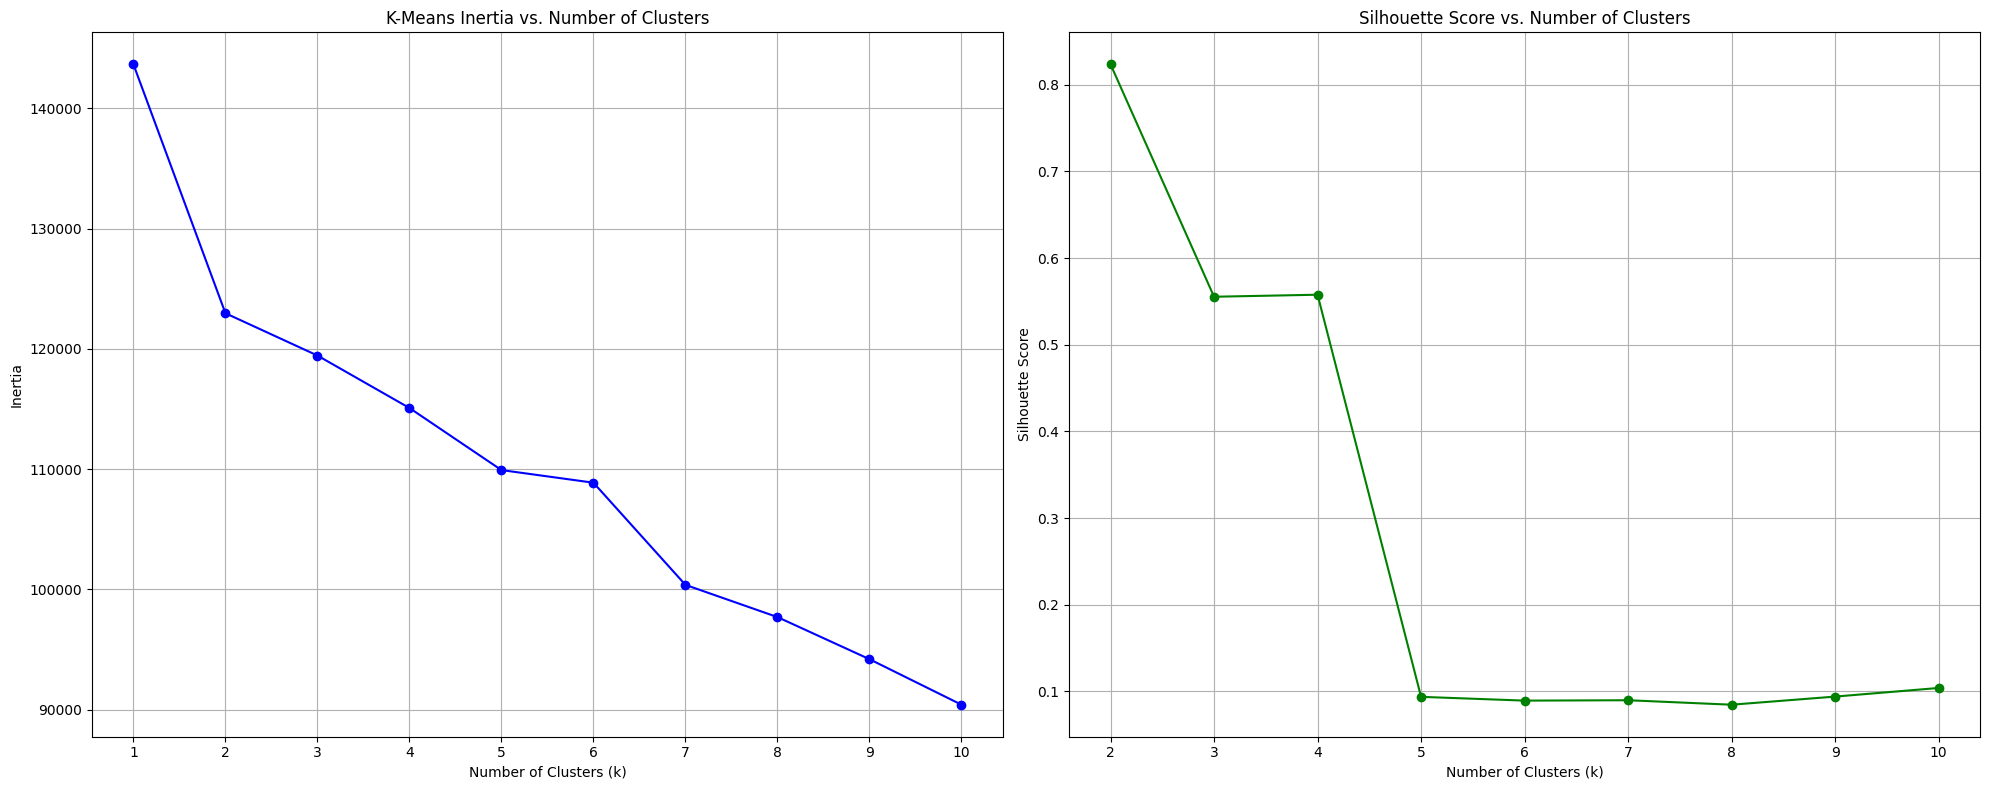

In [13]:
# Define the range for number of clusters
cluster_range_inertia = range(1, 11)
inertia = []
cluster_range_silhouette = range(2, 11)
silhouette_avg = []

# Calculate inertia and silhouette scores for different k
print("\nEvaluating K-Means Clustering...")
for k in cluster_range_inertia:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    if k >= 2:
        score = silhouette_score(X_pca, kmeans.labels_)
        silhouette_avg.append(score)
        print(f"K = {k}, Inertia = {kmeans.inertia_:.4f}, Silhouete Score = {score:.4f}")

# ---------------------------Plots-------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot K-Means Inertia vs. Number of Clusters
axes[0].plot(cluster_range_inertia, inertia, marker='o', color='blue')
axes[0].set_title('K-Means Inertia vs. Number of Clusters')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(cluster_range_inertia)
axes[0].grid(True)

# Plot Silhouette Score vs. Number of Clusters
axes[1].plot(cluster_range_silhouette, silhouette_avg, marker='o', color='green')
axes[1].set_title('Silhouette Score vs. Number of Clusters')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(cluster_range_silhouette)
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 2.6: Preprocessing Dataset After Dimensionality Reduction and Adding Cluster Features


In [14]:
# Determination of optimal number of clusters based on silhouete scores
optimal_k = silhouette_avg.index(max(silhouette_avg)) + 2  # +2 because silhouette_avg starts from k=2
print(f"\nOptimal number of clusters determined to be: {optimal_k}")

# Initialise and fit KMeans with optimal_k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(X_pca)

# Predict clusters for the entire dataset
clusters = kmeans_optimal.labels_

# Assigning cluster labels to PCA and TSNE dataframes
pca_df['Cluster'] = clusters
tsne_df['Cluster'] = clusters[:tsne_df.shape[0]]

# Add Cluster Labels to PCA components
pca_with_cluster = pd.concat([pd.DataFrame(X_pca, columns=pca_columns),
                              pd.DataFrame({'Cluster': clusters})], axis=1)




Optimal number of clusters determined to be: 2


## 2.7: Outliers Removal


In [15]:
# Define outliers based on silhouete scores below 0.2
silhouette_vals_pca = silhouette_samples(X_pca, clusters)
pca_df['Silhouette_Val_pca'] = silhouette_vals_pca

# Identify outliers
outliers_pca = pca_df[pca_df['Silhouette_Val_pca'] < 0.2]
print(f"\nNumber of outliers based on PCA KMeans silhouete scores: {outliers_pca.shape[0]}")

# Identify non-outlier indices
non_outliers_pca = pca_df[pca_df['Silhouette_Val_pca'] >= 0.2].index

# Remove outliers from the feature matrix and labels variables
X_features_final = df_X_features.loc[non_outliers_pca].reset_index(drop=True)
y_category_final = data['Category_encoded'].loc[non_outliers_pca].reset_index(drop=True)
y_region_final = data['Region_encoded'].loc[non_outliers_pca].reset_index(drop=True)
y_bestagent_final = data['BestAgent_encoded'].loc[non_outliers_pca].reset_index(drop=True)

print("\nFinal feature data shape after outlier removal:", X_features_final.shape)
print("Final label matricies shapes after outlier removal: ")
print("Category:", y_category_final.shape)
print("Region:", y_region_final.shape)
print("BestAgent:", y_bestagent_final.shape)



# Dictionary to store train_test_splits after outliers removal and avoid incoming conflict
train_test_splits_final = {}
new_features = X_features_final.values
for target, y_target in zip(targets, [y_category_final, y_region_final, y_bestagent_final]):
    print(f"\nPerforming final train_test_split for label: ({target})")

    # Check if any class has only 1 sample
    class_counts = y_target.value_counts()
    if any(class_counts < 2):
        print(f"Warning: Label '{target}' has classes with less than 2 samples. Stratification not be possible. :( ")
        # Proceed without stratification
        stratify_param = None
    else:
        stratify_param = y_target

    X_train, X_test, y_train, y_test = train_test_split(
        new_features,
        y_target,
        test_size=0.2,
        random_state=42,
        stratify=stratify_param  # adjusts stratification parameter if condtional unmet
    )
    train_test_splits_final[target] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    print(f"Training Features Shape: {X_train.shape}")
    print(f"Testing Features Shape: {X_test.shape}")
    print(f"Training Target '{target}' Shape: {y_train.shape}")
    print(f"Testing Target '{target}' Shape: {y_test.shape}")



Number of outliers based on PCA KMeans silhouete scores: 2

Final feature data shape after outlier removal: (401, 379)
Final label matricies shapes after outlier removal: 
Category: (401,)
Region: (401,)
BestAgent: (401,)

Performing final train_test_split for label: (Category)
Training Features Shape: (320, 379)
Testing Features Shape: (81, 379)
Training Target 'Category' Shape: (320,)
Testing Target 'Category' Shape: (81,)

Performing final train_test_split for label: (Region)
Training Features Shape: (320, 379)
Testing Features Shape: (81, 379)
Training Target 'Region' Shape: (320,)
Testing Target 'Region' Shape: (81,)

Performing final train_test_split for label: (BestAgent)
Training Features Shape: (320, 379)
Testing Features Shape: (81, 379)
Training Target 'BestAgent' Shape: (320,)
Testing Target 'BestAgent' Shape: (81,)


# 3: Grid Search Cross-Validation - Tuning Hyperparameters

## 3.1: Define Parameter Grids for Each Base Model

In [22]:
# Parameter grids for each base model
param_grids = {
    'RandomForest': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10],
        'min_samples_leaf': [1],
        'min_samples_split': [2],
        'n_estimators': [100, 200]
    },
    'SVC': {
        'C': [0.1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf'],
        'probability': [True]
    },
    'KNeighbors': {
        'n_neighbors': [5],
        'weights': ['distance'],
        'metric': ['manhattan', 'euclidean'],
        'algorithm': ['auto'],
        'n_jobs': [-1]
    },
    'GradientBoosting': {
        'learning_rate': [0.01],
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'loss': ['log_loss'],
        'subsample': [0.8, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1],
        'algorithm': ['SAMME.R']
    },
    'XGBoost': {
        'booster': ['gbtree'],
        'learning_rate': [0.01],
        'n_estimators': [200],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
}


# Defined function to perform GridsearchCV
def perform_grid_search(model, param_grid, X_train, y_train, scoring='accuracy', cv=5):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    print(f"\nBest hyperparameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"\nBest {scoring}: {((grid_search.best_score_)*100):.2f}%\n")
    print('-'*25)
    return grid_search.best_estimator_


## 3.2: Performing GridSearchCV()

In [23]:
# Dictionary to store best estimators for each target
best_estimators = {target: {} for target in targets}

# Iterate through each target and perform grid search for each model
for target_name in targets:
    print(f"Performing Grid Search for label: ({target_name}), wait boss. \n{'```'*40}")

    X_train = train_test_splits_final[target_name]['X_train']
    y_train = train_test_splits_final[target_name]['y_train']

    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    best_rf = perform_grid_search(rf, param_grids['RandomForest'], X_train, y_train)
    best_estimators[target_name]['RandomForest'] = best_rf

    # SVC
    svc = SVC(random_state=42)
    best_svc = perform_grid_search(svc, param_grids['SVC'], X_train, y_train)
    best_estimators[target_name]['SVC'] = best_svc

    # KNeighbors
    knn = KNeighborsClassifier()
    best_knn = perform_grid_search(knn, param_grids['KNeighbors'], X_train, y_train)
    best_estimators[target_name]['KNeighbors'] = best_knn

    # Gradient Boosting
    gb = GradientBoostingClassifier(random_state=42)
    best_gb = perform_grid_search(gb, param_grids['GradientBoosting'], X_train, y_train)
    best_estimators[target_name]['GradientBoosting'] = best_gb

    # AdaBoost
    ada = AdaBoostClassifier(random_state=42)
    best_ada = perform_grid_search(ada, param_grids['AdaBoost'], X_train, y_train)
    best_estimators[target_name]['AdaBoost'] = best_ada


    # XGBoost - excluded for 'Region'
    if target_name != 'Region':
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        best_xgb = perform_grid_search(xgb, param_grids['XGBoost'], X_train, y_train)
        best_estimators[target_name]['XGBoost'] = best_xgb
    else:
        print("Skipping XGBoost for 'Region' target as per requirement.\n")

    print(f"\nCompleted GridsearchCV for label: {target_name}\n{'='*30}\n")

print("Grid Search completed for all models and labels! x_x'")

Performing Grid Search for label: (Category), wait boss. 
````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best hyperparameters for RandomForestClassifier: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best accuracy: 95.94%

-------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best hyperparameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}

Best accuracy: 91.25%

-------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best hyperparameters for KNeighborsClassifier: {'algorithm': 'auto', 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}

Best accuracy: 89.06%

-------------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best hyperparameters f

# 4: Training and Evaluating Random Forest Classifier Model

Training a Random Forest Classifier model for label: (Category), please wait...
--------------------------------------------------------------------------------

Classification Report for Random Forest Classifier ('Category'):
              precision    recall  f1-score   support

        Hunt       1.00      1.00      1.00        13
      Puzzle       1.00      1.00      1.00         1
        Race       0.92      1.00      0.96        12
         Sow       0.94      1.00      0.97        15
       Space       1.00      1.00      1.00        14
         War       1.00      0.92      0.96        26

    accuracy                           0.98        81
   macro avg       0.98      0.99      0.98        81
weighted avg       0.98      0.98      0.98        81

-----------------------------------


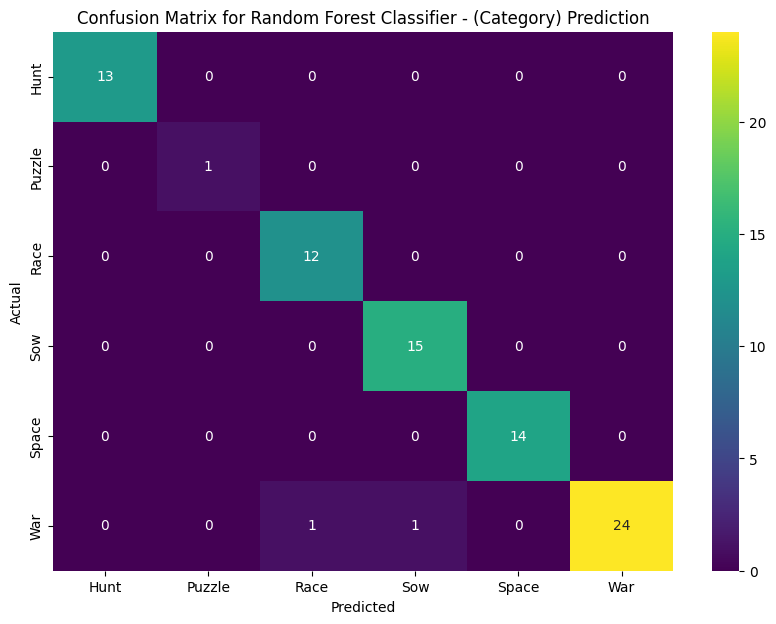

Accuracy: 0.395
Precision: 0.424
Recall: 0.395
F1 Score: 0.382

Training a Random Forest Classifier model for label: (Region), please wait...
--------------------------------------------------------------------------------

Classification Report for Random Forest Classifier ('Region'):
                   precision    recall  f1-score   support

        Caribbean       0.00      0.00      0.00         2
     Central Asia       0.00      0.00      0.00         1
   Eastern Africa       0.56      0.71      0.62         7
     Eastern Asia       0.00      0.00      0.00         5
   Eastern Europe       0.00      0.00      0.00         0
       Micronesia       0.00      0.00      0.00         1
    Middle Africa       0.00      0.00      0.00         3
  Northern Africa       0.75      0.38      0.50         8
 Northern America       0.33      0.33      0.33         3
    Northern Asia       0.11      0.33      0.17         3
  Northern Europe       0.40      0.29      0.33         7
Sout

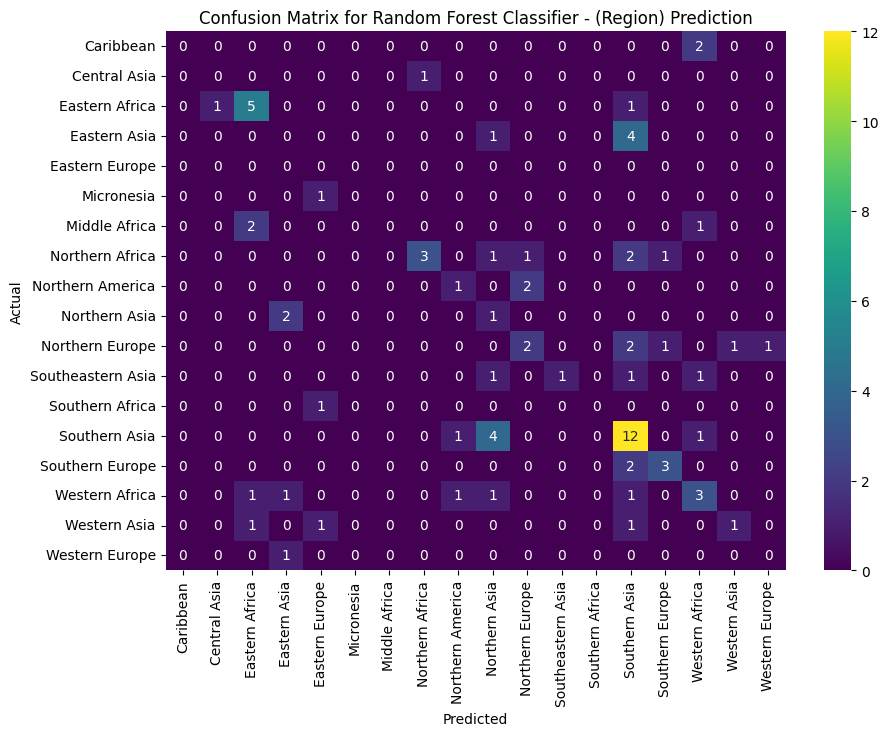

Accuracy: 0.395
Precision: 0.424
Recall: 0.395
F1 Score: 0.382

Training a Random Forest Classifier model for label: (BestAgent), please wait...
--------------------------------------------------------------------------------

Classification Report for Random Forest Classifier ('BestAgent'):
                     precision    recall  f1-score   support

         Alpha-Beta       0.65      0.87      0.75        47
               MAST       0.08      0.09      0.09        11
           MC-GRAVE       0.00      0.00      0.00         2
Progressive History       0.33      0.14      0.20         7
             Random       0.00      0.00      0.00         3
                UCT       0.33      0.09      0.14        11

           accuracy                           0.54        81
          macro avg       0.23      0.20      0.20        81
       weighted avg       0.46      0.54      0.48        81

-----------------------------------


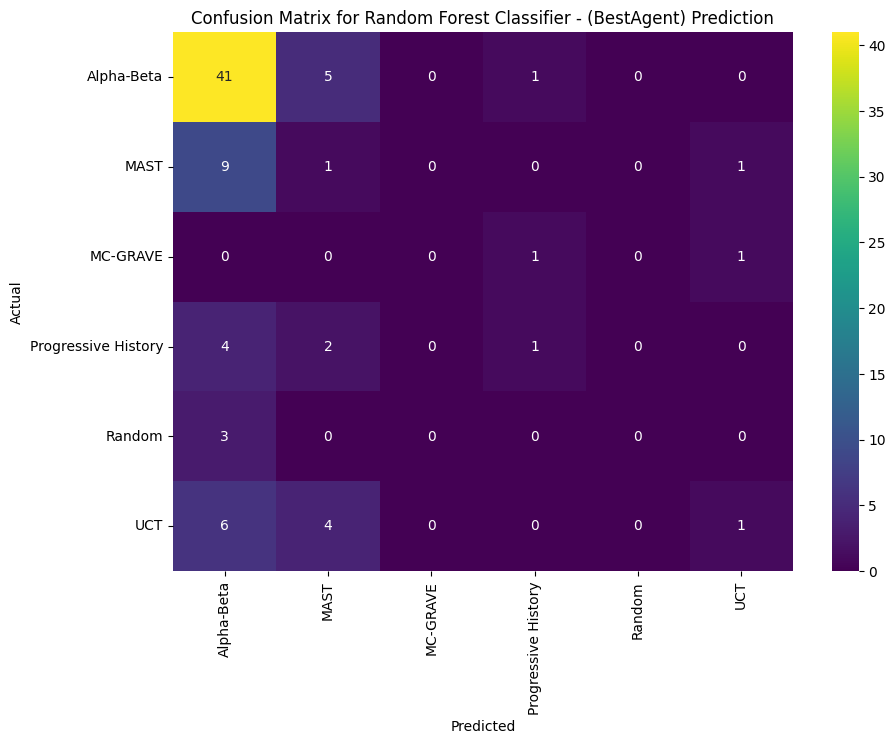

Accuracy: 0.395
Precision: 0.424
Recall: 0.395
F1 Score: 0.382



In [37]:
# Dictionary to store Random Forest Classifier encoded labels
label_encoders = {
    'category': le_category,
    'region': le_region,
    'bestagent': le_bestagent
}

# List of targets
targets = ['Category', 'Region', 'BestAgent']

# Dictionary to store Random Forest Classifiers labels
standalone_rf = {target: None for target in targets}

for target_name in targets:
    print(f"Training a Random Forest Classifier model for label: ({target_name}), please wait...\n{'-'*80}")

    best_rf = best_estimators[target_name]['RandomForest']
    X_test = train_test_splits_final[target_name]['X_test']
    y_test = train_test_splits_final[target_name]['y_test']

    # Fit the model on training data
    best_rf.fit(train_test_splits_final[target_name]['X_train'], train_test_splits_final[target_name]['y_train'])

    # Predict on the test data
    y_pred_rf = best_rf.predict(X_test)

    # Store the trained model
    standalone_rf[target_name] = best_rf

    # Evaluation Metrics
    print(f"\nClassification Report for Random Forest Classifier ('{target_name}'):")

    # Checks if a label encoder exists for the target
    if target_name.lower() in label_encoders:
        le = label_encoders[target_name.lower()]

        # Get unique labels from y_test and y_pred_rf
        unique_labels = sorted(set(y_test) | set(y_pred_rf))

        # Inverting transform -> to get class names for unique labels only
        target_names = le.inverse_transform(unique_labels).astype(str)

        # Filtering y_test_labels and y_pred_labels using `labels` argument
        print(classification_report(y_test, y_pred_rf, labels=unique_labels, target_names=target_names))

    else:
        # If no label encoder, conditional uses the unique sorted labels instead
        unique_labels = sorted(set(y_test) | set(y_pred_rf))
        target_names = [str(label) for label in unique_labels]

        # Using unique_labels as labels here as well
        print(classification_report(y_test, y_pred_rf, labels=unique_labels, target_names=target_names))

    print('-'*35)

    # Confusion Matrix
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf, labels=unique_labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='viridis',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Random Forest Classifier - ({target_name}) Prediction')
    plt.show()

    # Additional Metrics
    accuracy_rf = accuracy_score(y_test_labels, y_pred_labels)
    precision_rf = precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    recall_rf = recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
    f1_rf = f1_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy_rf:.3f}")
    print(f"Precision: {precision_rf:.3f}")
    print(f"Recall: {recall_rf:.3f}")
    print(f"F1 Score: {f1_rf:.3f}\n{'='*80}\n")

# 5: Training and Evaluating Stacking Ensemble Model


Training Stacking Ensemble model for label: (Category)
--------------------------------------------------

Classification Report for Stacking Ensemble Model ('Category'):
              precision    recall  f1-score   support

        Hunt       0.87      1.00      0.93        13
      Puzzle       0.00      0.00      0.00         1
        Race       1.00      0.83      0.91        12
         Sow       0.94      1.00      0.97        15
       Space       0.93      0.93      0.93        14
         War       0.96      0.96      0.96        26

    accuracy                           0.94        81
   macro avg       0.78      0.79      0.78        81
weighted avg       0.93      0.94      0.93        81

-----------------------------------

Confusion Matrix


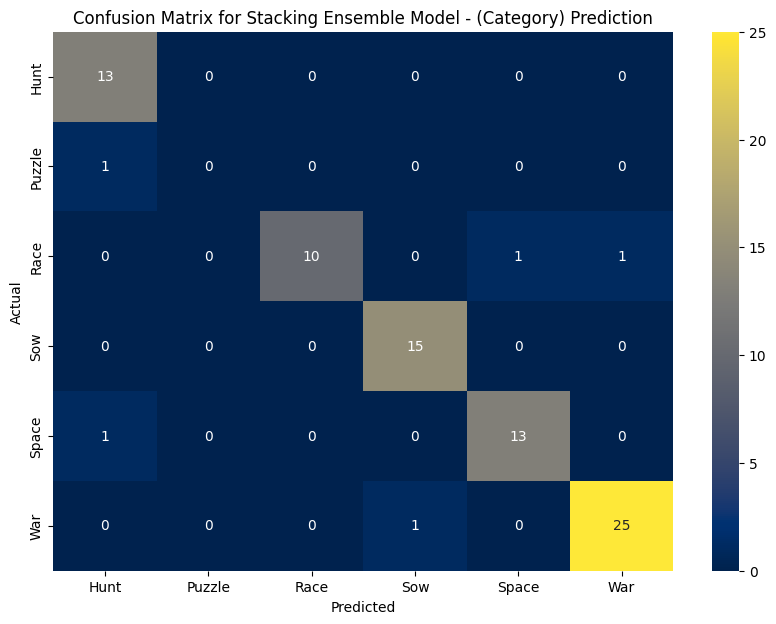

Accuracy: 0.938
Precision: 0.930
Recall: 0.938
F1 Score: 0.932

Training Stacking Ensemble model for label: (Region)
--------------------------------------------------

Classification Report for Stacking Ensemble Model ('Region'):
                   precision    recall  f1-score   support

        Caribbean       0.00      0.00      0.00         2
  Central America       0.00      0.00      0.00         0
     Central Asia       0.00      0.00      0.00         1
   Eastern Africa       0.62      0.71      0.67         7
     Eastern Asia       0.20      0.20      0.20         5
   Eastern Europe       0.00      0.00      0.00         0
       Micronesia       0.00      0.00      0.00         1
    Middle Africa       0.00      0.00      0.00         3
  Northern Africa       0.75      0.38      0.50         8
 Northern America       0.25      0.33      0.29         3
    Northern Asia       0.00      0.00      0.00         3
  Northern Europe       0.17      0.14      0.15         7
 

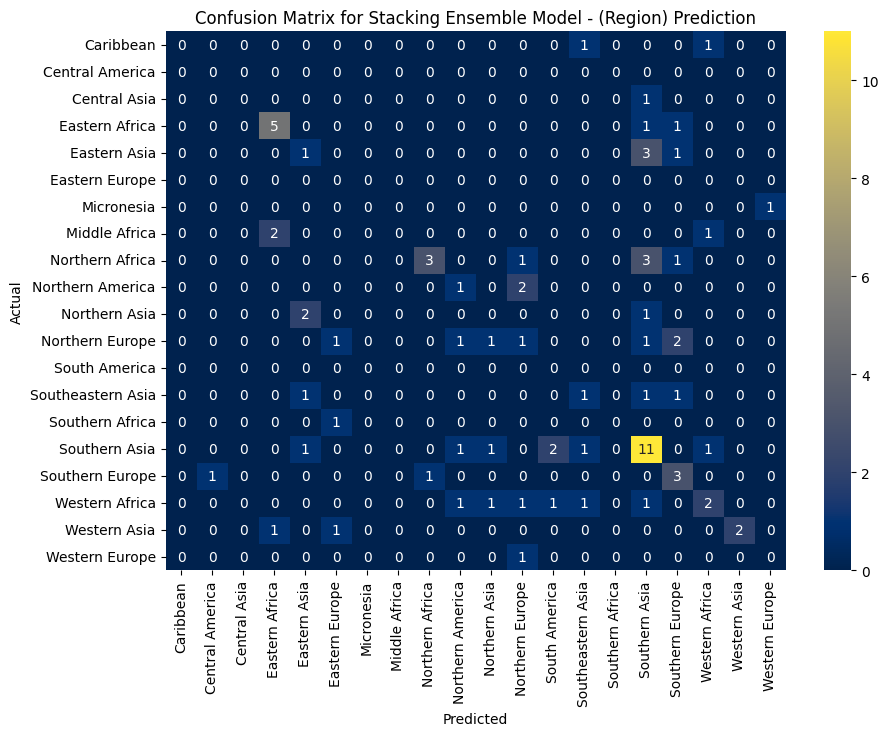

Accuracy: 0.370
Precision: 0.392
Recall: 0.370
F1 Score: 0.365

Training Stacking Ensemble model for label: (BestAgent)
--------------------------------------------------

Classification Report for Stacking Ensemble Model ('BestAgent'):
                     precision    recall  f1-score   support

         Alpha-Beta       0.69      0.79      0.73        47
               MAST       0.20      0.18      0.19        11
           MC-GRAVE       0.00      0.00      0.00         2
Progressive History       0.00      0.00      0.00         7
             Random       0.00      0.00      0.00         3
                UCT       0.09      0.09      0.09        11

           accuracy                           0.49        81
          macro avg       0.16      0.18      0.17        81
       weighted avg       0.44      0.49      0.46        81

-----------------------------------

Confusion Matrix


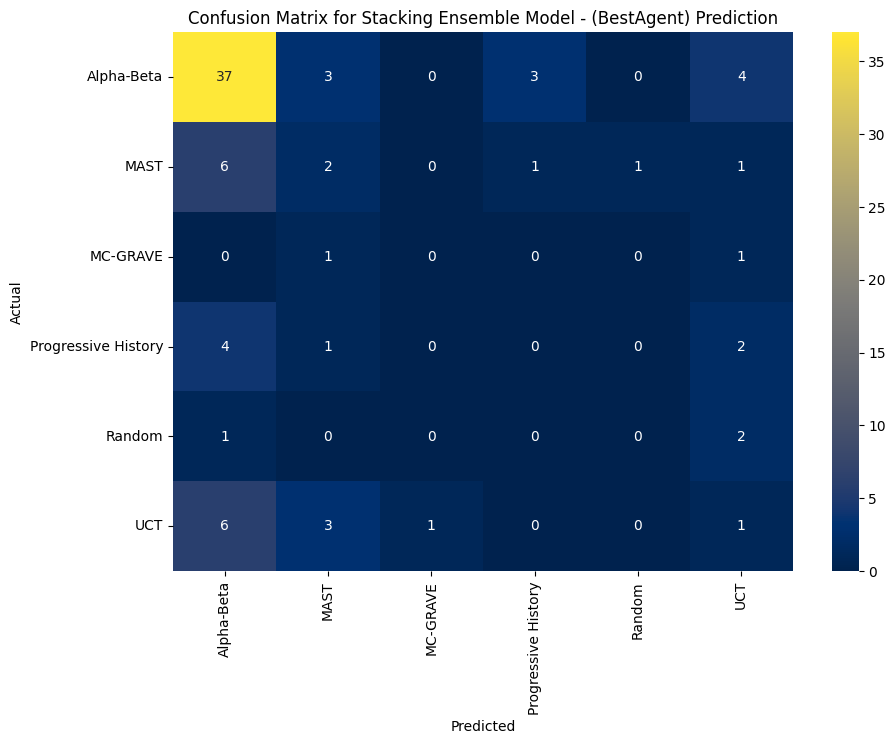

Accuracy: 0.494
Precision: 0.437
Recall: 0.494
F1 Score: 0.463

Stacking Ensemble Model finished successfully.


In [36]:
# Dictionary to store Stacking Classifiers
stacking_classifiers = {target: None for target in targets}

for target_name in targets:
    print(f"Training Stacking Ensemble model for label: ({target_name})\n{'-'*50}")

    # Check if 'XGBoost' is in best_estimators[target_name]
    if 'XGBoost' in best_estimators[target_name]:
        estimators = [
            ('RandomForest', best_estimators[target_name]['RandomForest']),
            ('SVC', best_estimators[target_name]['SVC']),
            ('KNeighbors', best_estimators[target_name]['KNeighbors']),
            ('GradientBoosting', best_estimators[target_name]['GradientBoosting']),
            ('AdaBoost', best_estimators[target_name]['AdaBoost']),
            ('XGBoost', best_estimators[target_name]['XGBoost'])
        ]
    else:
        # Exclude XGBoost FOR label if condition unmet --> This is for Region
        print(f"Warning: 'XGBoost' was excluded for label '({target_name})'.")
        estimators = [
            ('RandomForest', best_estimators[target_name]['RandomForest']),
            ('SVC', best_estimators[target_name]['SVC']),
            ('KNeighbors', best_estimators[target_name]['KNeighbors']),
            ('GradientBoosting', best_estimators[target_name]['GradientBoosting']),
            ('AdaBoost', best_estimators[target_name]['AdaBoost']),
        ]

    # Define the meta-learner for stacking
    final_estimator = LogisticRegression(random_state=42, max_iter=1000)

    # Initialise the Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1,
        passthrough=True
    )

    X_train = train_test_splits_final[target_name]['X_train']
    y_train = train_test_splits_final[target_name]['y_train']
    X_test = train_test_splits_final[target_name]['X_test']
    y_test = train_test_splits_final[target_name]['y_test']

    # Train the Stacking Classifier
    stacking_clf.fit(X_train, y_train)

    # Store the trained model
    stacking_classifiers[target_name] = stacking_clf

    # Predict on the test data
    y_pred_stack = stacking_clf.predict(X_test)

    # Evaluation Metrics
    print(f"\nClassification Report for Stacking Ensemble Model ('{target_name}'):")

    # Check for label encoders and get target names
    if target_name.lower() in label_encoders:
        le = label_encoders[target_name.lower()]
        unique_labels = sorted(set(y_test) | set(y_pred_stack))
        target_names = le.inverse_transform(unique_labels).astype(str)
        print(classification_report(y_test, y_pred_stack, labels=unique_labels, target_names=target_names))
    else:
        # Fallback: use the unique labels directly
        unique_labels = sorted(set(y_test) | set(y_pred_stack))
        target_names = [str(label) for label in unique_labels]
        print(classification_report(y_test, y_pred_stack, labels=unique_labels, target_names=target_names))

    # Confusion Matrix
    print('-'*35)
    print("\nConfusion Matrix")
    conf_matrix_stack = confusion_matrix(y_test, y_pred_stack, labels=unique_labels)
    plt.figure(figsize=(10, 7))

    sns.heatmap(conf_matrix_stack, annot=True, fmt='d', cmap='cividis',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Stacking Ensemble Model - ({target_name}) Prediction')
    plt.show()

    # Additional Metrics
    accuracy_stack = accuracy_score(y_test, y_pred_stack)
    precision_stack = precision_score(y_test, y_pred_stack, average='weighted', zero_division=0)
    recall_stack = recall_score(y_test, y_pred_stack, average='weighted', zero_division=0)
    f1_stack = f1_score(y_test, y_pred_stack, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy_stack:.3f}")
    print(f"Precision: {precision_stack:.3f}")
    print(f"Recall: {recall_stack:.3f}")
    print(f"F1 Score: {f1_stack:.3f}\n{'='*50}\n")

print('='*50)
print("Stacking Ensemble Model finished successfully.")


# 6: Cross-Validation for Random Forest Classifier and Stacking Ensemble Models


In [44]:
print("\nCross-Validation for Random Forest Classifier and Stacking Ensemble models:\n")
for target_name in targets:
    # Standalone Random Forest
    print(f"Cross-Validation for Random Forest Classifier model ('{target_name}')\n{'-'*50}")
    rf_model = standalone_rf[target_name]
    cv_scores_rf = cross_val_score(
        rf_model,
        X_features_final,
        y_category_final if target_name == 'Category' else
        y_region_final if target_name == 'Region' else
        y_bestagent_final,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    print(f"Cross-Validation Scores (Accuracy): {cv_scores_rf}")
    print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f}")
    print(f"Std CV Accuracy: {cv_scores_rf.std():.4f}")
    print(f"\n{'='*50}\n")

    # Stacking Classifier
    print(f"Cross-Validation for Stacking Ensemble model ('{target_name}')\n{'-'*50}")
    stacking_model = stacking_classifiers[target_name]
    cv_scores_stack = cross_val_score(
        stacking_model,
        X_features_final,
        y_category_final if target_name == 'Category' else
        y_region_final if target_name == 'Region' else
        y_bestagent_final,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    print(f"Cross-Validation Scores (Accuracy): {cv_scores_stack}")
    print(f"Mean CV Accuracy: {cv_scores_stack.mean():.4f}")
    print(f"{'='*50}")



Cross-Validation for Random Forest Classifier and Stacking Ensemble models:

Cross-Validation for Random Forest Classifier model ('Category')
--------------------------------------------------
Cross-Validation Scores (Accuracy): [0.95061728 0.95       0.9625     0.95       0.9625    ]
Mean CV Accuracy: 0.9551
Std CV Accuracy: 0.0060


Cross-Validation for Stacking Ensemble model ('Category')
--------------------------------------------------
Cross-Validation Scores (Accuracy): [0.9382716 0.925     0.95      0.925     0.9625   ]
Mean CV Accuracy: 0.9402
Cross-Validation for Random Forest Classifier model ('Region')
--------------------------------------------------
Cross-Validation Scores (Accuracy): [0.41975309 0.45       0.425      0.425      0.375     ]
Mean CV Accuracy: 0.4190
Std CV Accuracy: 0.0244


Cross-Validation for Stacking Ensemble model ('Region')
--------------------------------------------------
Cross-Validation Scores (Accuracy): [0.39506173 0.35       0.3625     0.4  

# 7: Final Cross-Validation Testing on Unseen Dataset (GameData_Predictions.csv)


## 7.1: Preprocessing Datasets


In [49]:
# Load the testing GamerData_Predictions.csv prediction dataset
data_predictions = pd.read_csv('GameData_Predictions.csv')
print("\nPrediction Data Snapshot:")
print(data_predictions.head())

# Ensuring select columns that exist in both dataframes (data, and data_prediction)
columns_to_keep_pred = list(set(data.columns) & set(data_predictions.columns))
# Insure the prediction dataset has the same columns as the training dataset (excluding the labels and encoded labels columns and game name)
columns_to_keep_pred = [col for col in columns_to_keep_pred if col not in ['GameName', 'Category', 'Region', 'BestAgent', 'UCT', 'Category_encoded', 'Region_encoded', 'BestAgent_encoded']]

data_predictions = data_predictions[columns_to_keep_pred]

# Ensure all features are imputed
X_features_predictions = pd.DataFrame(imputer.fit_transform(data_predictions), columns=columns_to_keep_pred)

# Standardize the features
X_features_scaled_predictions = pd.DataFrame(scaler.fit_transform(X_features_predictions), columns=columns_to_keep_pred)

print("\nShape of scaled prediction features matrix:", X_features_scaled_predictions.shape)

target_feature_mappings = {
    'Category': 'Category_encoded',
    'Region': 'Region_encoded',
    'BestAgent': 'BestAgent_encoded'
}




Prediction Data Snapshot:
                   GameName  String_java.lang.String  Off_int  End_int  \
0          Main Tapak Empat                        7        0        0   
1          Boxijn Barildaan                        4        0        0   
2                Provincial                        8        1        0   
3  Tsoro Additional Capture                       18        0        0   
4         Marelle Quadruple                        7        0        0   

   int_int  Undefined_int  Piece_game.equipment.component.Piece  \
0        5              0                                     2   
1       66              0                                     1   
2       37              0                                     1   
3       15              0                                     1   
4       28              0                                     1   

   Board_game.equipment.container.board.Board  \
0                                           1   
1                          

## 7.2: Performing Cross-Validation on Random Forest Classifier and Stacking Ensemble Models


In [50]:

print("\nFinal Cross-Validation Testing on Unseen Dataset:\n")
print('='*50)
for target_name in target_feature_mappings.keys():
    #  Random Forest
    print(f"Cross-Validation for Random Forest Classifier model ('{target_name}')\n{'-'*50}")
    best_rf = standalone_rf[target_name]
    cv_scores_rf = cross_val_score(
        best_rf,
        X_features_final,
        y_category_final,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    print(f"Cross-Validation Scores: {cv_scores_rf}")
    print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f}")
    print(f"Std CV Accuracy: {cv_scores_rf.std():.4f}")
    print(f"\n{'='*50}\n")

    # Stacking Classifier
    print(f"Cross-Validation for Stacking Ensemble model ('{target_name}')\n{'-'*50}")
    stacking_clf = stacking_classifiers[target_name]
    cv_scores_stack = cross_val_score(
        stacking_clf,
        X_features_final,
        y_category_final,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    print(f"Cross-Validation Scores: {cv_scores_stack}")
    print(f"Mean CV Accuracy: {cv_scores_stack.mean():.3f}")
    print(f"Std CV Accuracy: {cv_scores_stack.std():.3f}\n{'='*50}\n")

print("Final Cross-Validation testing completed on GameData_Predections.csv dataset. ")


Final Cross-Validation Testing on Unseen Dataset:

Cross-Validation for Random Forest Classifier model ('Category')
--------------------------------------------------
Cross-Validation Scores: [0.9382716 0.9625    0.975     0.95      0.975    ]
Mean CV Accuracy: 0.9602
Std CV Accuracy: 0.0143


Cross-Validation for Stacking Ensemble model ('Category')
--------------------------------------------------
Cross-Validation Scores: [0.9382716 0.95      0.975     0.8875    0.9375   ]
Mean CV Accuracy: 0.938
Std CV Accuracy: 0.029

Cross-Validation for Random Forest Classifier model ('Region')
--------------------------------------------------
Cross-Validation Scores: [0.9382716 0.9625    0.9875    0.95      0.975    ]
Mean CV Accuracy: 0.9627
Std CV Accuracy: 0.0175


Cross-Validation for Stacking Ensemble model ('Region')
--------------------------------------------------
Cross-Validation Scores: [0.92592593 0.95       0.9875     0.8875     0.9375    ]
Mean CV Accuracy: 0.938
Std CV Accuracy

# Appendix

## 1: Tried gridsearchCV hyperparamters

In [ ]:
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy', 'log_loss']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
        'n_jobs': [-1]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'loss': ['log_loss', 'exponential'],
        'subsample': [0.8, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1, 1.0],
        'algorithm': ['SAMME']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'booster': ['gbtree', 'gblinear', 'dart']
    }
}

def perform_grid_search(model, param_grid, X_train, y_train, scoring='accuracy', cv=5):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best {scoring}: {grid_search.best_score_:.4f}\n")
    return grid_search.best_estimator_


Performing Grid Search for target: Category
--------------------------------------------------
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy: 0.9502

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy: 0.9287

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best accuracy: 0.9007

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best accuracy: 0.9441

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for AdaBoostClassifier: {'

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best accuracy: 0.9565

Completed Grid Search for target: Category

Performing Grid Search for target: Region
--------------------------------------------------
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for RandomForestClassifier: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy: 0.4562

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for SVC: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.3723

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best accuracy: 0.3942

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best accuracy: 0.4129

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for AdaBoostClassifier: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}
Best accuracy: 0.2919

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], got [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20]

--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], got [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20]

--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], got [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 16 17 18 19 20]
